<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/Diferencias_en_Diferencias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

     |████████████████████████████████| 972kB 3.5MB/s 
     |████████████████████████████████| 14.7MB 304kB/s 
     |████████████████████████████████| 10.9MB 40.9MB/s 


# Investigando efectos del COVID en alquileres usando Diferencias en Diferencias


In [2]:
import geopandas as gpd
import numpy as np
data=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/urban-econometrics/blob/master/data/deptos_amba_0519_0520.zip?raw=true")
df=data.loc[data.l2=='Capital Federal'] # vamos a trabajar con la Capital Federal

In [3]:
df['airelibre']=np.where((df.patio=='1')| (df.terraza=='1'),1,0)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


¿Cuánto fue el alquiler promedio de un departamento tomando el año completo?


In [4]:
df.price.mean()

25351.83177693887

Exploramos la diferencia en diferencia \

$E[y|t=aire,Post]-E[y|t=aire,Pre]=\lambda_{POST}+\beta-\lambda_{PRE}$
$E[y|t=sinaire,Post]-E[y|t=sinaire,Pre]=\lambda_{POST}-\lambda_{PRE}$


In [5]:
dif_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==1)].price.mean()-df.loc[(df.postcovid==0)&(df.airelibre==1)].price.mean()
dif_airelibre

11670.161339485458

In [6]:
dif_sin_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==0)].price.mean()-df.loc[(df.postcovid==0)&(df.airelibre==0)].price.mean()
dif_sin_airelibre

8571.756202733664

In [7]:
dif_airelibre-dif_sin_airelibre

3098.405136751793

Misma cuenta en logs

In [8]:
df['logprice']=np.log(df.price)
df['logpricem2']=np.log(df.price/df.surface_to)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [9]:
dif_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==1)].logprice.mean()-df.loc[(df.postcovid==0)&(df.airelibre==1)].logprice.mean()
dif_sin_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==0)].logprice.mean()-df.loc[(df.postcovid==0)&(df.airelibre==0)].logprice.mean()
dif_airelibre-dif_sin_airelibre

0.017190559076601275

# Utilizando Regresión


In [10]:
df['DD']=df.postcovid*df.airelibre

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
import statsmodels.api as sm
def regress(lista, data):
    """ 
    Funcion que realiza la regresion OLS
    La primera variable de la lista es la dependiente, el resto son las explicativas
    data es la base de datos
    """
    datos=data[lista]
    # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
    datos=datos.dropna()
    Y=datos[lista[0]]
    X=datos[lista[1:]]
    X=sm.add_constant(X)
    modelo=sm.OLS(Y,X)
    resultados=modelo.fit()
    print(resultados.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
regress(['logprice','postcovid','airelibre','DD'],data=df)

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     196.4
Date:                Thu, 13 Aug 2020   Prob (F-statistic):          5.75e-125
Time:                        18:02:36   Log-Likelihood:                -10897.
No. Observations:               15099   AIC:                         2.180e+04
Df Residuals:                   15095   BIC:                         2.183e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9326      0.005   2087.057      0.0

In [13]:
regress(['price','postcovid','airelibre','DD'],data=df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     151.1
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           1.75e-96
Time:                        18:02:36   Log-Likelihood:            -1.6955e+05
No. Observations:               15099   AIC:                         3.391e+05
Df Residuals:                   15095   BIC:                         3.391e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.371e+04    174.158    136.150      0.0

In [20]:
df.start_date

'2019-07-28'

# Inspección gráfica del cumplimiento del supuesto de tendencias comunes

Vamos a mirar los promedios mensuales y por trimetre. Para eso voy a extraer de la fecha el mes-anio y el trimestre-anio correspondiente.


In [28]:
import pandas as pd
df['monthyear']=pd.to_datetime(df.start_date).dt.to_period('M')

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


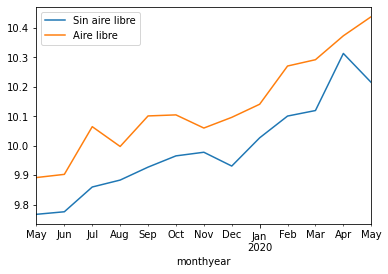

In [46]:
df_months=df.groupby(by=['monthyear','airelibre']).logprice.mean().rename('media').reset_index()
ax=df_months.loc[df_months.airelibre==0].plot(x='monthyear',y='media', label='Sin aire libre')
df_months.loc[df_months.airelibre==1].plot(x='monthyear',y='media', ax=ax, label='Aire libre')

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


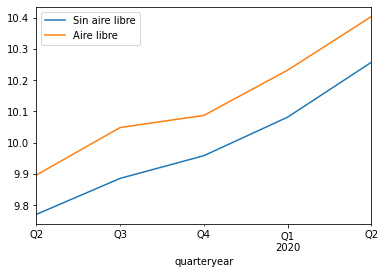

In [48]:
df['quarteryear']=pd.to_datetime(df.start_date).dt.to_period('Q')
df_quarters=df.groupby(by=['quarteryear','airelibre']).logprice.mean().rename('media').reset_index()
ax=df_quarters.loc[df_quarters.airelibre==0].plot(x='quarteryear',y='media', label='Sin aire libre')
df_quarters.loc[df_quarters.airelibre==1].plot(x='quarteryear',y='media', ax=ax, label='Aire libre')